# Лабораторная работа №3

### ФИО: Селина Елизавета Александровна
### Группа: БИВТ-23-СП-2

### Задание 1. 
Название датасета: **Students Performance in Exams** 

In [3]:
# Импорт стандартных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split #разделение данных на обучающую и тестовую выборку
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder #нормализация, приводит к диапазону от 0 до 1, кодировщик категориальных признаков
from sklearn.compose import ColumnTransformer #разные типы признаков обрабатывать по-разному
from sklearn.pipeline import Pipeline #конвейер обработки
from sklearn.impute import SimpleImputer

# Модели
from sklearn.linear_model import LogisticRegression #бинарная классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Метрики классификации
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score #Процент правильных ответов, компромисс между точнотью и полнотой, насколько хорошо модель отделяет один класс от другого
from sklearn.metrics import roc_curve, precision_recall_curve #Строит ROC-кривую, Строит PR-кривую

plt.rcParams['figure.figsize'] = (10, 6)

#Загрузка данных
df = pd.read_csv("StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


### Задание 2.
В датасете есть три числовых признака:
 - math score
 - reading score
 - writing score

Мы будем решать задачу **бинарной классификации**:
Студент считается **успешным (pass = 1)**, если средний балл ≥ 60, иначе **неуспешным (pass = 0)**.

In [5]:
# Вот тут мы как раз и превратили задачу в бинарную классификацию
df['avg_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)
df['pass'] = (df['avg_score'] >= 60).astype(int)

print(df['pass'].value_counts())
df[['avg_score', 'pass']].head()

pass
1    715
0    285
Name: count, dtype: int64


,avg_score,pass
0,72.666667,1
1,82.333333,1
2,92.666667,1
3,49.333333,0
4,76.333333,1


### Задание 3. Сделать предобработку данных.
#### Разделим выборку на тренировочную (train) и тестовую (test).

In [6]:
# Признаки и целевая переменная
X = df.drop(columns=['avg_score', 'pass']) #все колонки исходного DataFrame df, кроме 'avg_score' и 'pass'
y = df['pass']

# Разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y #шобы данные были разнообраные
)

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (750, 8)
Test: (250, 8)


In [7]:
#Разделим данные на численные и категориальные
numeric_features = ['math score', 'reading score', 'writing score']
categorical_features = [
    'gender',
    'race/ethnicity',
    'parental level of education',
    'lunch',
    'test preparation course'
]

#### Обработка пропусков (если бы они были)
В этом датасете пропусков нет.

#### Нормирование данных.

In [8]:
# Обработка численных:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # на случай пропусков, не стала убирать
    ('scaler', StandardScaler())                    # нормализация
])

#Обработка категориальных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#Объединяем:
preprocessor = ColumnTransformer(transformers=[ #весь процесс предобработки упакован в единый объект
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [9]:
X_train_trans = preprocessor.fit_transform(X_train) #обучает препроцессор вычисляет все необходимые параметры
X_test_trans  = preprocessor.transform(X_test)      #применяет эти вычисленные параметры к X_train и преобразует данные

print("Transformed shapes:", X_train_trans.shape, X_test_trans.shape)

#все параметры преобразований (медианы, параметры scaler'а, какие категории существуют) вычисляются на X_train. 
#Затем мы применяем уже вычисленные правила к X_test. Так мы исключаем утечку данных из теста в обучение.

Transformed shapes: (750, 20) (250, 20)


### Задание 4. Обучаем на тренировочном множестве.

In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree_depth_3': DecisionTreeClassifier(max_depth=3),
    'DecisionTree_depth_6': DecisionTreeClassifier(max_depth=6),
    'KNN_k_3': KNeighborsClassifier(n_neighbors=3),
    'KNN_k_7': KNeighborsClassifier(n_neighbors=7),
    'RandomForest_depth_6': RandomForestClassifier(max_depth=6, n_estimators=100, random_state=42),
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[ #Создает полный конвейер, предобработка данных - модель
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train) #Обучает весь пайплайн на обучающих данных (включая предобработку)

    y_train_pred = pipeline.predict(X_train) #елает предсказани на обучающих и тестовых данных
    y_test_pred = pipeline.predict(X_test)

    y_test_proba = pipeline.predict_proba(X_test)[:, 1] #Получает вероятности принадлежности к классу 1

    results[name] = {
        'model': pipeline,
        'acc_train': accuracy_score(y_train, y_train_pred),
        'acc_test': accuracy_score(y_test, y_test_pred),
        'f1_test': f1_score(y_test, y_test_pred), #(баланс точность и полнота)
        'roc_auc': roc_auc_score(y_test, y_test_proba), #(качество ранжирования)
        'y_test_proba': y_test_proba
    }

### Задание 5. Метрики качества.

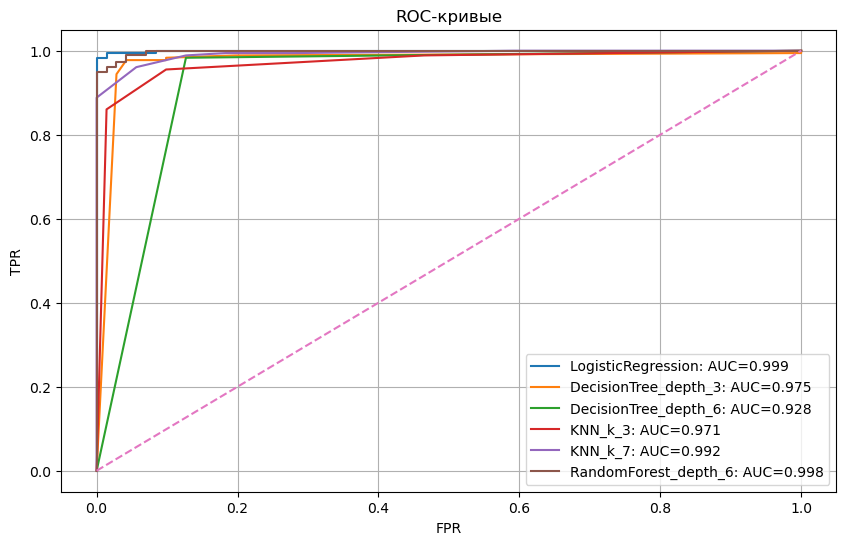

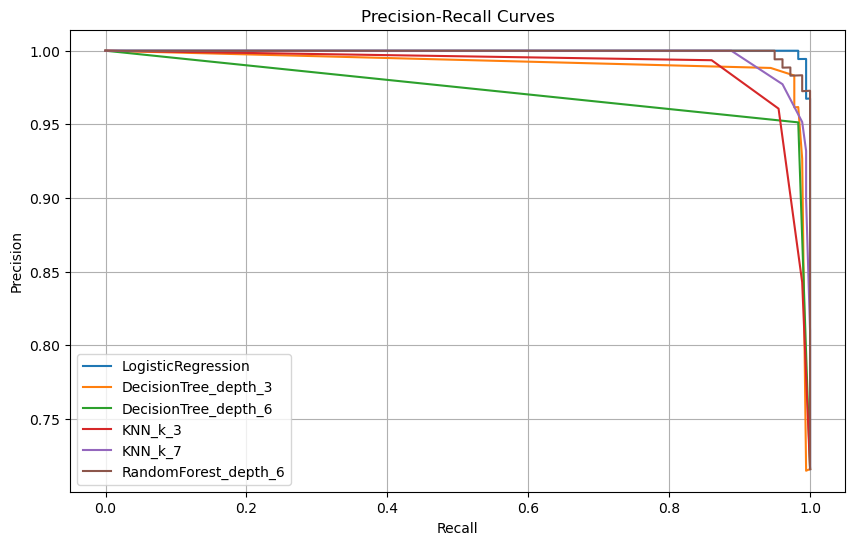

In [12]:
# ROC-кривые график, который показывает компромисс между двумя типами ошибок
plt.figure()
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_test_proba'])
    plt.plot(fpr, tpr, label=f"{name}: AUC={res['roc_auc']:.3f}") #площадь под кривой

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривые')
plt.legend()
plt.grid(True)
plt.show()


# Precision-Recall кривые это график, который показывает компромисс между двумя важными метриками для задач бинарной классификаци
plt.figure()
for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['y_test_proba'])
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
metrics_table = pd.DataFrame(results).T
metrics_table

,model,acc_train,acc_test,f1_test,roc_auc,y_test_proba
LogisticRegression,"(ColumnTransformer(transformers=[('num',\n ...",0.994667,0.988,0.991597,0.999371,"[0.9999999957855006, 0.9999999930435, 0.709176..."
DecisionTree_depth_3,"(ColumnTransformer(transformers=[('num',\n ...",0.984,0.96,0.972376,0.975214,"[0.998015873015873, 0.998015873015873, 0.90476..."
DecisionTree_depth_6,"(ColumnTransformer(transformers=[('num',\n ...",1.0,0.952,0.967033,0.92824,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
KNN_k_3,"(ColumnTransformer(transformers=[('num',\n ...",0.966667,0.94,0.957983,0.970965,"[1.0, 1.0, 0.6666666666666666, 1.0, 0.33333333..."
KNN_k_7,"(ColumnTransformer(transformers=[('num',\n ...",0.969333,0.956,0.969863,0.992092,"[1.0, 1.0, 0.5714285714285714, 1.0, 0.14285714..."
RandomForest_depth_6,"(ColumnTransformer(transformers=[('num',\n ...",1.0,0.976,0.983333,0.998033,"[0.9915292222989991, 0.9958076859397563, 0.616..."


### Задание 6. Выводы.

A. Лучшей моделью оказалась LogisticRegression, так как она показала:
 - максимальный ROC-AUC ≈ 0.999
 - высокую Accuracy
 - стабильную Precision-Recall кривую
Также очень близкий результат показал RandomForest.

B. Сильного переобучения не наблюдается, так как:
 - значения Accuracy на train и test близки,
 - ROC-AUC на тесте остаётся высоким,
 - кривые на тестовой выборке не деградируют.

C. Недообучения не наблюдается, так как:
 - все модели показывают AUC значительно выше 0.9,
 - Precision и Recall находятся на высоком уровне.

D. Метрики можно улучшить за счёт:
 - Подбора гиперпараметров через GridSearchCV,
 - Увеличения количества деревьев в RandomForest,
 - Подбора оптимального k в KNN,
 - Добавления новых информативных признаков,
 - Использования ансамблевых методов.